#### Tensorflow Logging

The code below disables the warning logging from the TensorFlow.

In [1]:
# Tensorflow logging: OFF
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#### Importing Testing & Training Datasets

The datasets are the following (<mark>both are saved under the directory Saved Datasets</mark>):
- Training_Binary.pkl
- Testing_Binary.pkl

In [2]:
import pickle as pkl
import pandas as pd
import os

FILENAME_DATASET = 'Dataset_Binary.pkl'
FILENAME_TESTING = 'Testing_Binary.pkl'
FILENAME_TRAINING = 'Training_Binary.pkl'
DIRECTORY = 'Saved Datasets'

dataset = os.path.join(DIRECTORY, FILENAME_DATASET)
dataset_training = os.path.join(DIRECTORY, FILENAME_TRAINING)
dataset_testing = os.path.join(DIRECTORY, FILENAME_TESTING)

# Loading Final Dataset
df = pd.read_csv('../../Datasets/BLE/BLE_Malicious_Dataset_Final.csv')
x_columns = df.columns.drop(['is_malicious'])
print(f'[DONE] Loading final dataset')

# Loading Dataset 
with open(dataset, 'rb') as f:
    x, y = pkl.load(f)
print(f'[DONE] Loading dataset')

# Loading Train Fraction 
with open(dataset_training, 'rb') as f:
    x_train, y_train = pkl.load(f)
print(f'[DONE] Loading train fraction')

# Loading Test Fraction 
with open(dataset_testing, 'rb') as f:
    x_test, y_test = pkl.load(f)
print(f'[DONE] Loading test fraction')

[DONE] Loading final dataset
[DONE] Loading dataset
[DONE] Loading train fraction
[DONE] Loading test fraction


#### Defining Metrics & Plots

The following sections defines the classification metrics used for the traditional machine learning algorithms used in this notebook. The metrics are:

- Recall
- Precision
- F1-Score

In [4]:
import tensorflow.keras
from tensorflow.keras import backend as K

# Metrics for real-time usage in the model below
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [6]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def conf_matrix(y_test, prediction, array_dimension = 2):
    if (array_dimension == 2):
        predict_classes = np.argmax(prediction, axis = 1)
        expected_classes = np.argmax(y_test, axis = 1)
    elif (array_dimension == 1):
        predict_classes = prediction
        expected_classes = y_test

    cm = confusion_matrix(expected_classes, predict_classes)
    cmd = ConfusionMatrixDisplay(cm, display_labels = ['Benign', 'Malicious'])

    fig, ax = plt.subplots(figsize = (6, 6))

    # Add axis labels and rotate them
    ax.set_xlabel('Predicted labels', rotation = 0, labelpad = 10)
    ax.set_ylabel('True labels', rotation = 90, labelpad = 10)

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Normal', 'Attack'], rotation = 0, ha = 'center', va = 'center')
    ax.set_yticklabels(['Normal', 'Attack'], rotation = 90, ha = 'center', va = 'center')

    ax.tick_params(axis = 'x', pad = 10)
    ax.tick_params(axis = 'y', pad = 10)

    cmd.plot(ax = ax, cmap = plt.cm.Blues)

In [7]:
# Extra Trees Classifier
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import numpy as np

def extra_tree_classifier(x_train, y_train, x_columns):
    # Usage of ExtraTreesClassifier for feature selection
    extra_tree_forest = ExtraTreesClassifier(n_estimators = 5, criterion = 'entropy', max_features = 2)
    extra_tree_forest.fit(x_train, y_train)
    feature_importances = extra_tree_forest.feature_importances_
    feature_importance_normalized = np.std([tree.feature_importances_ for tree in  extra_tree_forest.estimators_], axis = 0)

    # Plot the feature importances
    plt.figure(figsize = (10, 6))
    plt.bar(x_columns, feature_importance_normalized, align = 'center')
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Importance')
    plt.title('Comparison of different feature importances in the current dataset')
    plt.xticks(rotation = 90)
    plt.show()

#### Neural Network Model

This code sets up a neural network model using the TensorFlow and Keras libraries. The model architecture consists of three dense (fully connected) layers. The first layer has 50 units and uses the ReLU activation function, followed by a dropout layer that randomly sets 50% of the inputs to 0 during training to prevent overfitting. The second hidden layer has 25 units and also uses the ReLU activation function, followed by another dropout layer. The final output layer has a number of units equal to the number of classes in the output, and it uses the softmax activation function to produce probabilities for each class.

The model is compiled with the categorical cross-entropy loss function, the Adam optimizer, and a custom metric called f1_m. It then sets up two callbacks for training: EarlyStopping and ReduceLROnPlateau. EarlyStopping monitors the validation loss and stops training if there is no improvement for 10 consecutive epochs, helping prevent overfitting. ReduceLROnPlateau reduces the learning rate by a factor of 0.5 if the validation loss does not improve for 10 consecutive epochs, allowing the model to fine-tune its weights.

The model is trained using the fit() function on the provided training data (x_train and y_train), with validation data (x_test and y_test) used for evaluating the model's performance during training. The ReduceLROnPlateau callback is passed as a parameter to adjust the learning rate dynamically. The training is verbose (prints progress information) and runs for a maximum of 200 epochs.

Finally, the trained model is saved in the 'Saved_Models/Model_Binary.h5' file.

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Neural Network Model
model = Sequential()
model.add(Dense(50, input_dim = x.shape[1], activation = 'relu')) # Hidden 1
model.add(Dropout(0.5))
model.add(Dense(25, activation = 'relu')) # Hidden 2
model.add(Dropout(0.5))
model.add(Dense(y.shape[1], activation = 'softmax')) # Output
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = [f1_m])

# Early Stopping
monitor = EarlyStopping(
    monitor = 'val_loss', 
    min_delta = 1e-3, 
    patience = 10, 
    verbose = 1, 
    mode = 'auto', 
    restore_best_weights = True
)

# Reduce On Plateau
reduce = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.5,
    patience = 10,
    verbose = 1,
    mode = 'auto',
    min_lr = 1e-5
)

# Model
model.fit(
    x_train, 
    y_train, 
    validation_data = (x_test, y_test), 
    callbacks = [reduce],
    verbose = 2,
    epochs = 100
)

# Save the model
model.save('Saved Models/Model_Binary.h5')

Epoch 1/100
4562/4562 - 7s - loss: 0.0856 - f1_m: 0.9715 - val_loss: 0.0056 - val_f1_m: 0.9992 - lr: 0.0010 - 7s/epoch - 2ms/step
Epoch 2/100
4562/4562 - 5s - loss: 0.0110 - f1_m: 0.9984 - val_loss: 0.0057 - val_f1_m: 0.9992 - lr: 0.0010 - 5s/epoch - 1ms/step
Epoch 3/100
4562/4562 - 6s - loss: 0.0111 - f1_m: 0.9988 - val_loss: 0.0057 - val_f1_m: 0.9992 - lr: 0.0010 - 6s/epoch - 1ms/step
Epoch 4/100
4562/4562 - 6s - loss: 0.0106 - f1_m: 0.9988 - val_loss: 0.0056 - val_f1_m: 0.9992 - lr: 0.0010 - 6s/epoch - 1ms/step
Epoch 5/100
4562/4562 - 6s - loss: 0.0106 - f1_m: 0.9989 - val_loss: 0.0057 - val_f1_m: 0.9992 - lr: 0.0010 - 6s/epoch - 1ms/step
Epoch 6/100
4562/4562 - 6s - loss: 0.0100 - f1_m: 0.9989 - val_loss: 0.0057 - val_f1_m: 0.9992 - lr: 0.0010 - 6s/epoch - 1ms/step
Epoch 7/100
4562/4562 - 7s - loss: 0.0102 - f1_m: 0.9990 - val_loss: 0.0056 - val_f1_m: 0.9992 - lr: 0.0010 - 7s/epoch - 1ms/step
Epoch 8/100
4562/4562 - 6s - loss: 0.0094 - f1_m: 0.9989 - val_loss: 0.0058 - val_f1_m: 0.

Epoch 60/100
4562/4562 - 6s - loss: 0.0074 - f1_m: 0.9991 - val_loss: 0.0059 - val_f1_m: 0.9992 - lr: 3.1250e-05 - 6s/epoch - 1ms/step
Epoch 61/100

Epoch 61: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
4562/4562 - 6s - loss: 0.0069 - f1_m: 0.9992 - val_loss: 0.0058 - val_f1_m: 0.9992 - lr: 3.1250e-05 - 6s/epoch - 1ms/step
Epoch 62/100
4562/4562 - 6s - loss: 0.0077 - f1_m: 0.9991 - val_loss: 0.0058 - val_f1_m: 0.9992 - lr: 1.5625e-05 - 6s/epoch - 1ms/step
Epoch 63/100
4562/4562 - 6s - loss: 0.0086 - f1_m: 0.9991 - val_loss: 0.0059 - val_f1_m: 0.9992 - lr: 1.5625e-05 - 6s/epoch - 1ms/step
Epoch 64/100
4562/4562 - 6s - loss: 0.0079 - f1_m: 0.9991 - val_loss: 0.0059 - val_f1_m: 0.9992 - lr: 1.5625e-05 - 6s/epoch - 1ms/step
Epoch 65/100
4562/4562 - 7s - loss: 0.0069 - f1_m: 0.9992 - val_loss: 0.0058 - val_f1_m: 0.9992 - lr: 1.5625e-05 - 7s/epoch - 1ms/step
Epoch 66/100
4562/4562 - 6s - loss: 0.0068 - f1_m: 0.9991 - val_loss: 0.0058 - val_f1_m: 0.9992 - lr: 1.5625e-0

In [8]:
# Output of hyperparameters stats used in model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                1500      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 25)                1275      
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 52        
                                                                 
Total params: 2,827
Trainable params: 2,827
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Prediction
pred = model.predict(x_test)

1521/1521 [==============================] - 1s 876us/step


In [10]:
from sklearn import metrics

# Metrics for the classification
def compute_metrics(pred, y_test):
    predict_classes = np.argmax(pred, axis = 1)
    expected_classes = np.argmax(y_test, axis = 1)
    
    correct = metrics.accuracy_score(expected_classes, predict_classes)
    print(f"Accuracy: {correct}")
    
    recall = metrics.recall_score(expected_classes, predict_classes, average = 'weighted')    
    print(f"Recall: {recall}")
       
    precision = metrics.precision_score(expected_classes, predict_classes, average = 'weighted')
    print(f"Precision: {precision}")
    
    f1score = metrics.f1_score(expected_classes, predict_classes, average = 'weighted')
    print(f"F1-Score: {f1score}")
    
compute_metrics(pred, y_test)

Accuracy: 0.9991573841917054
Recall: 0.9991573841917054
Precision: 0.9991586934912777
F1-Score: 0.9991573967573434



[CMATRIX] DNN Model Confusion Matrix


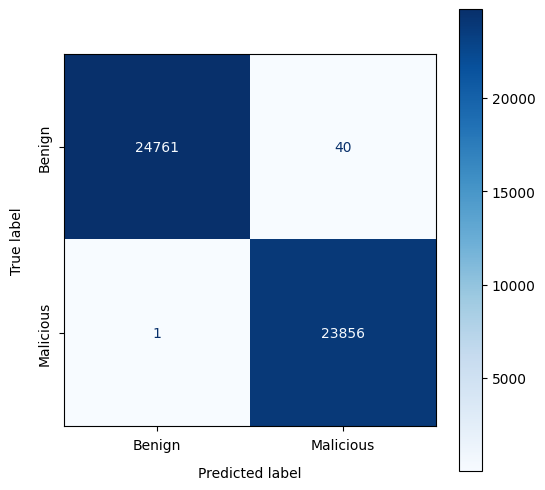

In [11]:
print(f'[CMATRIX] DNN Model Confusion Matrix')
conf_matrix(y_test, pred)


[CMATRIX] DNN Model Extra Tree Classifier


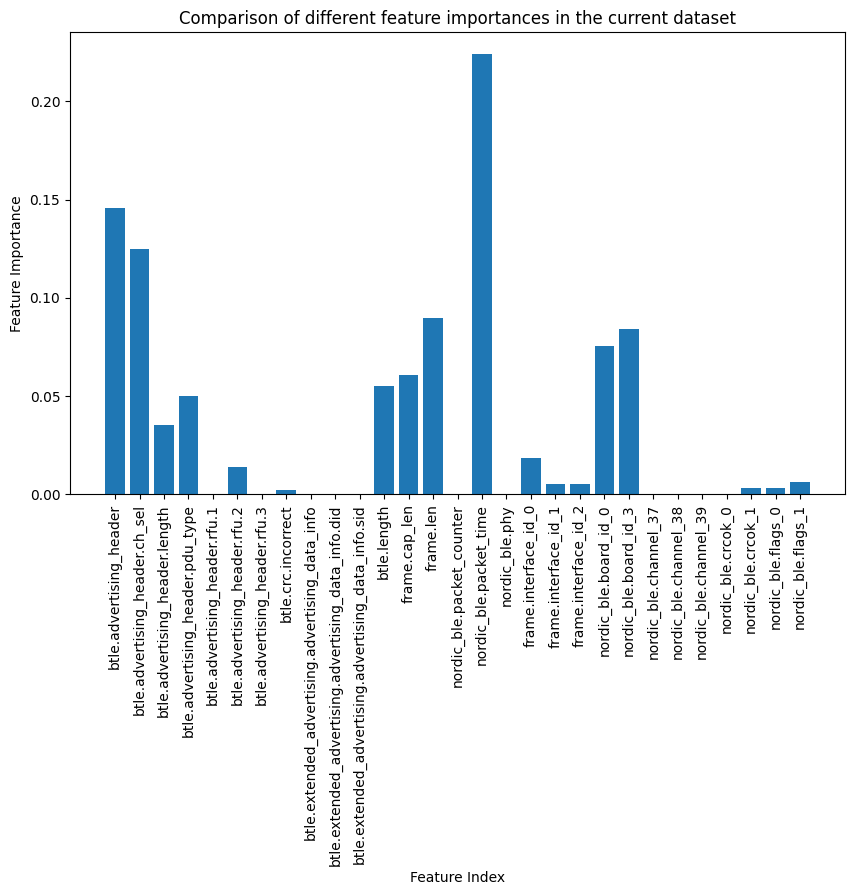

In [12]:
print(f'\n[CMATRIX] DNN Model Extra Tree Classifier')
extra_tree_classifier(x, y, x_columns)